<a href="https://colab.research.google.com/github/noa-blenkitny/IR_Project/blob/main/testing_and_evaluations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import auth
auth.authenticate_user()


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from pathlib import Path

In [4]:
from IPython.core.display import Math
from inverted_index_gcp import InvertedIndex
from inverted_index_gcp import MultiFileReader
from inverted_index_gcp import MultiFileWriter
import math
import numpy as np
import builtins #probably won't need this once we have our indexes
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
import re
from collections import OrderedDict, Counter, defaultdict
import hashlib
from heapq import heappop, heappush, heapify #we use it for searching
from time import time #we use it for testing
from contextlib import closing #we use it for read posting list
import pickle

reading titles_dict

In [5]:
with open('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/titles_dict.pkl', 'rb') as f:
  titles_dict = pickle.loads(f.read())

reading page rank

In [6]:
with open('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/pr.pkl', 'rb') as f:
  pr = pickle.loads(f.read())

reading page views

In [7]:
with open('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/pv.pkl', 'rb') as f:
  pv = pickle.loads(f.read())

reading indexes

In [8]:
# title_index = InvertedIndex.read_index('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/',"title_index")
# body_index = InvertedIndex.read_index('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/',"body_index")
# anchor_index = InvertedIndex.read_index('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/',"anchor_index")


In [9]:
bm25_T = InvertedIndex.read_index('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/',"bm25_T")
bm25_B = InvertedIndex.read_index('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/',"bm25_B")
bm25_A = InvertedIndex.read_index('/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/',"bm25_A")


In [10]:
queries=[(1,{'question':"python",'relevance_assessments': [23862, 23329, 53672527, 21356332, 4920126, 5250192, 819149, 46448252, 83036, 88595, 18942, 696712, 2032271, 1984246, 5204237, 645111, 18384111, 3673376, 25061839, 271890, 226402, 2380213, 1179348, 15586616, 50278739, 19701, 3596573, 4225907, 19160, 1235986, 6908561, 3594951, 18805500, 5087621, 25049240, 2432299, 381782, 9603954, 390263, 317752, 38007831, 2564605, 13370873, 2403126, 17402165, 23678545, 7837468, 23954341, 11505904, 196698, 34292335, 52042, 2247376, 15858, 11322015, 13062829, 38833779, 7800160, 24193668, 440018, 54351136, 28887886, 19620, 23045823, 43003632, 746577, 1211612, 8305253, 14985517, 30796675, 51800, 964717, 6146589, 13024, 11583987, 57294217, 27471338, 5479462]}),
 (2,{'question':"data science",'relevance_assessments': [35458904, 2720954, 54415758, 233488, 12487489, 48364486, 487132, 416589, 27051151, 66414222, 18985040, 4141563, 376707, 67092078, 61624594, 59591015, 49681, 55052729, 31663650, 35757264, 63995662, 3461736, 56499662, 43003632, 26685, 10147369, 24932989, 66982525, 5323, 46207323, 8495, 31915311, 51552534, 64057049, 45443335, 37849704, 42149032, 63198823, 38833779, 26880450, 39171985, 5213, 44133735, 28486111, 48972018, 23943140, 17740009, 49954680, 28326718, 63016369, 56023027, 58731, 55207134, 62798611, 65732625, 58255666, 68181697, 47892671, 1309220, 65499427, 58255600, 47638279, 46626475, 46374359, 53343108, 173332, 7671, 18745015, 50565707, 57143357, 45112545, 63148404, 50533783, 51112472, 49281083, 51505979, 1181008, 56731447, 59116880, 51578025, 21462612, 1765779, 39675445, 42253]}),
 (3,{'question':"migraine",'relevance_assessments': [21035, 36984150, 2702930, 25045060, 24224679, 2555865, 36579642, 310429, 22352499, 11495285, 22294424, 234876, 40748148, 69893, 61962436, 62871079, 843361, 7362700, 16982268, 15712244, 5690287, 7362738, 600236, 12410589, 26584776, 3332410, 20038918, 739855, 1015919, 14201682, 24361010, 53035710, 22901459, 57672434, 4206029, 738384, 36579839, 188521, 15325435, 3602651, 40428462, 322197, 19592340, 3868233, 2385806, 2933438, 23174077, 14001660, 2425344, 288328, 21381229, 26585811, 12652799, 322210, 51078678, 621531, 685130, 11193835, 21197980, 21078348, 3108484, 692988, 31556991, 18741438, 3053003, 50977642, 55115883, 17208913, 64269900, 54077917, 36666029, 50083054, 28245491, 5692662, 18353587, 1994895, 21364162, 20208066, 38574433, 910244, 6154091, 67754025, 2132969, 61386909, 18600765, 579516]}),
 (4,{'question':"chocolate",'relevance_assessments': [7089, 6693851, 6672660, 23159504, 49770662, 167891, 2399742, 100710, 76723, 5290678, 54229, 3881415, 3720007, 32652613, 1471058, 5239060, 1421165, 1730071, 1277918, 7419133, 17720623, 1765026, 19079925, 1979873, 497794, 57947, 15007729, 85655, 4250574, 2386481, 228541, 55225594, 318873, 22631033, 27767967, 7061714, 8175846, 3881265, 3046256, 606737, 845137, 16161419, 3098266, 54573, 11323402, 936243, 39280615, 13687674, 47155656, 7151675, 43627595, 26879832, 43098662, 2333593, 349448, 2052211, 4432842, 56412300, 1411016, 2152015, 3502051, 33372192, 61422444, 2385217, 1217747, 24315397, 7082459, 856246, 6050655, 27162455, 52140446, 37243595, 36961531, 245067, 1148978, 1770825, 976322, 10300434, 7249348, 14945749, 62851606, 637004, 16224368, 18509922]}),
 (5,{'question':"how to make pasta",'relevance_assessments': [25659792, 50404581, 29178, 3080697, 90267, 2568868, 3450096, 49647732, 462173, 43911472, 20229, 40478583, 56643734, 21257512, 2387344, 59405867, 1330188, 12638661, 501757, 446865, 4468939, 25215235, 456363, 95411, 30916, 53487581, 30876926, 301932, 47764842, 426522, 579040, 54155622, 60535326, 23852947, 4275382, 67279077, 16591942, 334546, 602599, 3735620, 10296674, 858120, 30876121, 443480, 1038309, 50653758, 2258995, 34121672, 5382150, 884056, 3141956, 349722, 6745, 3511512, 35211682, 611752, 66963891, 43977806, 36742560, 2899729, 5413930, 61742595, 6972293, 14926, 42674415, 193957, 1950442, 3396753, 2269888, 40055348, 63609800, 1343426, 26078050, 44808, 42444204, 35034191, 9303405, 4627535, 59407816, 28732, 1187122, 6984468, 3328852, 56313776, 43853813, 3533082, 1032674, 39797382, 8892877]}),
 (6,{'question':"Does pasta have preservatives?",'relevance_assessments':[50404581, 301932, 30876121, 12727781, 37018026, 382599, 56232, 1032674, 202437, 9759063, 2047222, 11309920, 15015154, 46482, 406363, 39813131, 9785087, 47840259, 230716, 2240648, 49380722, 62153, 64083, 5355, 1330224, 17345999, 36969, 50577743, 31919750, 1197035, 2175, 15003673, 54145741, 42801, 458008, 47150650, 67922, 39390739, 901091, 28771786, 6984468, 416752, 382619, 198153, 49065540, 496821, 3112548, 15434651, 237489, 47862672, 915309, 708662, 21699434, 550448, 22893145, 17055183, 32863238, 13824676, 1300923, 746225, 33065713, 47770304, 32593, 11002, 20156275, 22735258, 31156754, 32587, 2077960, 344611, 5652480, 31425310, 991758, 40956516, 594987, 1093416, 26473291, 877461, 340356, 13679, 1558639, 11832915, 926863, 14953848, 42155809, 54923, 276975, 66554, 5775715, 3133549, 1104286, 26951370, 3240723, 6523448, 3902658]}),
 (7,{'question':"how google works",'relevance_assessments': [44674524, 1092923, 12431, 224584, 43419164, 9874319, 4338696, 3190097, 9651444, 33321947, 26334893, 1497849, 47489893, 32639051, 2030607, 60903, 19133401, 42411494, 47799755, 4028754, 42960975, 24386465, 5339378, 1494648, 14181749, 58582001, 10062721, 33039125, 286747, 48736239, 33367993, 50575063, 55633178, 29403992, 34113322, 3660182, 25173473, 62438513, 60904, 3235536, 40867519, 5376827, 44424763, 58708106, 64302888, 187946, 29156200, 46426771, 35847782, 5376796, 25295524, 33768164, 46551547, 773423, 5376868, 49931371, 59539691, 22411575, 35326347, 46493906, 11451897, 10619416, 36891093, 40116717, 23533163, 879962, 502593, 3371574, 43194901, 41815118, 35673556, 6575642, 43997189, 5913182, 2126501, 52840911, 1566175, 42951365, 42694174, 22992426, 466299, 736238, 7301470, 1431181, 48653985, 51328172, 12003767]}),
 (8,{'question':"what is information retrieval",'relevance_assessments': [15271, 494530, 442684, 19988623, 731640, 24997830, 10179411, 16635934, 33407925, 11486091, 50716473, 35804330, 18550455, 21106742, 4694434, 26591446, 296950, 24963841, 346470, 509628, 261193, 28688670, 10218640, 1897206, 39000674, 17785794, 38156944, 9586885, 743971, 1185840, 7872152, 10328235, 36794719, 509624, 5818361, 25935906, 22254915, 4881262, 39585214, 30882491, 57312392, 3781784, 25959000, 14109784, 10818378, 25957127, 9511414, 6422823, 20289869, 15101979, 48317971, 14343887, 762092, 4840292, 25130414, 7602386, 37131566, 6118940, 56598843, 11184711, 1315248, 12101316, 22809006, 29979321, 149354, 32817039, 25271852, 20948989, 36749242, 26143506, 19542049, 360030, 20632884, 24963451, 30874683, 11647367, 383162, 13200719, 1981660, 53123104, 10715937, 24019253, 25050663, 27511028, 1514191]}),
 (9,{'question':"NBA",'relevance_assessments': [22093, 16795291, 65166616, 65785063, 835946, 890793, 3921, 450389, 20455, 987153, 240940, 246185, 9000355, 5608488, 3280233, 3505049, 5958023, 72852, 8806795, 1811390, 2423824, 516570, 15392541, 72893, 412214, 278018, 12106552, 42846434, 12754503, 9807715, 4108839, 33328593, 64063961, 7215125, 1811320, 1111137, 5035602, 60483582, 9397801, 255645, 16899, 43376, 72855, 65785040, 72866, 6215230, 4987149, 72878, 16160954, 243389, 64639133, 38958735, 72858, 27196905, 38153033, 1385825, 9733533, 49926096, 4875689, 4750398, 28754077, 43569250, 22092, 72889, 59798759, 49778089, 346029, 8588996, 1956255, 52454088, 25390847, 31667631, 878666, 48695845, 72857, 459304, 27837030, 17107550, 72861, 54859596, 9195892, 6560301, 72875, 72883, 240989, 3196517, 24612090]}),
 (10,{'question':"yoga",'relevance_assessments': [34258, 59580357, 315141, 47035547, 626718, 32016617, 59516988, 61583621, 38424, 196789, 734272, 60851303, 988753, 92222, 419015, 60992198, 621809, 83742, 3127300, 23834216, 1381751, 744158, 18911094, 1817874, 59052395, 43562594, 31793047, 6154795, 17452177, 62342792, 13936750, 60805249, 60823333, 59899027, 46719542, 7702313, 60310807, 44270128, 68489731, 60500106, 1652601, 359983, 60300514, 45482242, 34756533, 58520592, 43611227, 47586513, 1775374, 6933106, 13412771, 62549131, 49278248, 62557135, 4523354, 60468426, 666420, 1017009, 35795560, 34843274, 60199413, 16488467, 29828807, 585681, 41757168, 66018807, 61285582, 1226448, 28848113, 11487904, 4242777, 1661867, 10671559, 44035836, 6931929, 60705564, 61690747, 7343803, 9042644, 36991237, 3965223, 63090179, 632990, 1041815, 53087254, 418999, 1632919]}),
 (11,{'question':"how to not kill plants",'relevance_assessments': [952429, 53916, 4189740, 5132315, 5818788, 35270055, 246674, 28271176, 18952739, 13323241, 1257003, 39562449, 11286, 1440567, 294295, 718110, 5806056, 3587235, 515758, 70129, 11984, 25228985, 1572831, 28125449, 1101651, 8220315, 149463, 63883178, 43937, 432174, 55775421, 2413296, 54019, 1878531, 57559, 1822951, 44568, 10104316, 16671094, 59988, 2068329, 12174150, 18952424, 48340, 83024, 99951, 4390795, 4954263, 3012923, 43344741, 61932070, 1480987, 2520434, 15880608, 7852272, 33084611, 27377596, 57866, 22438472, 8150951, 1265113, 19828134, 76046, 37774, 9270823, 1421709, 2051423, 7173874, 59400, 3606300, 8846, 38980932, 427577, 589513, 147484, 3883838, 29565262, 1527015, 533214, 10669865, 32591, 992052, 4975851, 44629591, 162296, 3513027, 11921706, 9041235, 1068768, 5498413, 591668, 42586177, 1185479, 514894, 3419, 14174833, 71265, 7218230]}),
 (12,{'question':"masks",'relevance_assessments': [63631542, 821829, 633458, 63567907, 14208718, 7912947, 159546, 67759831, 7439323, 64192678, 40909056, 5322079, 63164437, 31728348, 12772, 1402997, 1156703, 1840653, 568164, 1814699, 2945076, 2565663, 442333, 33567480, 468313, 19718702, 987724, 903187, 1485962, 5003908, 4201044, 28086000, 28844729, 1265651, 4659608, 64966775, 55960921, 8970797, 4301719, 35892659, 2248622, 6939163, 48561519, 261396, 34298473, 12263290, 44258772, 25219375, 149426, 6558203, 46567337, 46784964, 6458321, 46576311, 18823362, 48315099, 56440599, 57159776, 74910, 67891964, 1702593, 560306, 1015304, 705756, 7479199, 57772096, 58946599, 1210300, 15716827, 34336876, 9040490, 439102, 264104, 11061915, 39774839, 34735506, 42174581, 66859257, 3293969, 16315, 23166476, 42812440, 66935753, 51990351, 36619752, 59863622, 38404, 64027932]}),
 (13,{'question':"black friday",'relevance_assessments': [366477, 21000624, 3252816, 29437250, 2399020, 2675881, 360797, 184979, 20775117, 3233153, 31185151, 67528700, 31265743, 31526583, 157649, 60421513, 58847654, 360789, 5089316, 37168, 29772915, 29448480, 63351334, 3136619, 8076709, 41047099, 48658625, 50394170, 2621344, 25496814, 2997690, 41956157, 8817935, 19283335, 3738164, 60383204, 29449433, 20302560, 664951, 580517, 21434255, 8304348, 21611071, 55449550, 27555169, 28153175, 39614564, 314544, 31102405, 1428872, 19952476, 59540110, 40704884, 193714, 8948452, 49891754, 24008586, 32047012, 1104969, 54632, 31323977, 28253219, 33538385, 177671, 3286723, 16368206, 25351191, 5549127, 184959, 52708523, 728321, 31186864, 57685061, 240148, 22067678, 20827796, 4681, 41958461]}),
 (14,{'question':"why do men have nipples",'relevance_assessments': [150389, 412643, 48475515, 2775579, 4489, 997303, 250247, 311440, 42669424, 1080173, 2295417, 1243208, 1045845, 1890951, 4668823, 1027896, 7364325, 6613094, 8001012, 45079706, 580715, 5866454, 6383976, 18611260, 28643, 2581217, 5686025, 49998617, 63011479, 54736719, 20913864, 52146943, 34900078, 756765, 344269, 254067, 10916, 1764686, 25211041, 28456222, 35334391, 3845894, 34354998, 403653, 46745914, 11415141, 2252455, 283858, 65217527, 3223727, 42549636, 22546, 581077, 7971671, 21496150, 1104090, 21496038, 12082283, 24385806, 575890, 7105280, 54863336, 36164, 1752731, 3611109, 106121, 50364362, 3039817, 38041, 2968175, 70547, 13502823, 36881878, 702635, 18838, 15179951, 286455, 7139331, 218406, 1130867, 21490868, 1025265, 498971, 12915125, 4819795, 49458922, 23446323, 1244458]}),
 (15,{'question':"rubber duck",'relevance_assessments': [599738, 21905962, 39322520, 2608233, 12234103, 6264793, 6497307, 39303262, 54655786, 3378227, 64516, 41300601, 27898480, 672302, 1793236, 1765938, 1179787, 22503790, 43399069, 6263016, 31468446, 23030371, 1540241, 38904159, 11882165, 43707, 54406331, 3275717, 3781845, 57228339, 312903, 16308445, 8277225, 864249, 3115732, 15190087, 2541491, 1923274, 37400147, 47987665, 978408, 36835927, 2589070, 559356, 19696772, 17069844, 13315204, 34829413, 23454546, 2045055, 311935, 37674, 582735, 52077192, 4463369, 11760348]}),
 (16,{'question':"michelin",'relevance_assessments': [2036409, 79732, 35052231, 644781, 50991931, 51729995, 56721897, 60583278, 4512778, 53866975, 31728660, 636344, 48286897, 2550824, 66591573, 1360573, 52882803, 1761526, 56758995, 52971602, 2575380, 59519477, 1343949, 53748793, 66029904, 17284321, 62380392, 8250222, 1044117, 37032671, 51478870, 11216001, 2947322, 60085976, 1291991, 9483388, 11231759, 22513329, 5046302, 35927164, 43610835, 2074655, 52076814, 66846904, 58067594, 3997367, 9547083, 16348889, 16184595, 44972706, 37026554, 36753304, 65601792, 66605355, 34964813, 10873990, 13235623, 46302846, 37297021, 3463398, 32739936, 2337323]}),
 (17,{'question':"what to watch",'relevance_assessments': [55840499, 40475635, 48308444, 65766671, 175537, 7235116, 164376, 42262371, 60883, 53066659, 989858, 302808, 37331423, 18948312, 4552880, 13612929, 55864774, 35729649, 1350109, 52766120, 147143, 55411770, 6920292, 38539, 29831, 23776, 20840, 50276487, 3470969, 59480957, 617668, 33279717, 63704575, 65693607, 57944031, 27306717, 1732642, 32255505, 37061023, 43379979, 19508643, 58150649, 2381862, 21899417, 40438099, 40030145, 6405787, 504230, 925736, 60446377, 37669357, 44146329, 54647064, 66938917, 64704775, 169672, 40867822, 5230872, 66259016, 67736156, 13690215, 342398, 57579192, 394697, 33757091, 55825336, 1068736, 2009711, 47778072, 41451023, 35306910, 31607, 56789255, 18383702, 1492414, 37901793, 2650227, 7152087, 60587209, 818234, 66814247, 59800766, 2387993, 66255918, 63241742, 4765530, 27375211, 21863425, 618856]}),
 (18,{'question':"best marvel movie",'relevance_assessments': [57069491, 65967176, 42163310, 878659, 27306717, 41677925, 1074657, 44240443, 17296107, 60952488, 43603241, 22114132, 46208997, 36450985, 41974555, 56289672, 60616450, 59502488, 33038861, 61699239, 61651800, 39368416, 29129051, 55935213, 54537218, 62372638, 60774345, 63090183, 37497391, 51430647, 67229718, 9110929, 61329320, 44254295, 41974496, 200563, 58481694, 48530084, 56289572, 22144990, 612052, 59162931, 55511148, 55511147, 61073786, 59892, 36484005, 36484254, 66423851, 62482816, 1275470, 5676692, 7927053, 60754840, 26999426, 60744481, 56289553, 60463979, 701741, 60283633, 1129847, 36439749, 4451883, 55511155, 22144721, 45359871, 723126, 43655965, 57275457, 12673434, 43867095, 26763420, 39293265, 15003874, 41668588, 61592102, 67063919, 11891433, 64057670, 61513780, 39345917, 67063906, 1221476, 41008758, 60587000, 7729, 2152196, 5027882, 509738, 403585, 26866372, 1339248, 3473503, 4148655]}),
 (19,{'question':"how tall is the eiffel tower",'relevance_assessments': [9232, 31655286, 4465969, 50230910, 35392555, 17664319, 548182, 148869, 34080, 64487, 12232, 38253534, 1278990, 705310, 1849140, 37882040, 305175, 41731654, 5486819, 38345627, 222491, 48534532, 61371, 5065635, 1273047, 881491, 40797848, 6788, 10000, 595149, 43617005, 64437720, 580320, 24001, 5052869, 5028853, 6112, 43825684, 22910214, 13338662, 16990777, 39902695, 7424280, 2040288, 3945278, 167585, 1632912, 13065408, 59917348, 27218900, 1884312, 4539416, 71899, 38342244, 308868, 12629761, 61402898, 19931851, 66273148, 384286, 5763069, 19437928, 8166922, 4649105, 1525546, 26775738, 671331, 2730731]}),
 (20,{'question':"where does vanilla flavoring come from",'relevance_assessments': [828085, 32623, 228190, 25311310, 1183972, 240668, 1808135, 10133081, 9917505, 297576, 10591, 5961225, 12897776, 4105482, 27944015, 7368588, 31591921, 431786, 64085, 12209015, 3342275, 21828, 42416319, 7082459, 48212, 529439, 7089, 704826, 228234, 225870, 3651805, 2837891, 976456, 3214240, 23054130, 54587, 8073864, 40783886, 48936348, 634940, 222266, 62149, 25342571, 167891, 241559, 4456418, 7778546, 50280699, 19886, 1188562, 249116, 6690, 35292743, 60862228, 3546873, 348499, 60088597, 113092, 180251, 7438610, 2668736, 55539, 849869, 3111871, 54840207, 64088, 2005216, 507776, 1124192, 304091, 49090939, 39727947, 1063168, 56069398, 84241, 1670565, 3631020, 566114, 1471058, 4979006, 1902624, 1613163, 654732, 937047, 16749463, 2142071, 30224834, 2208584, 34482422, 41580016, 2190209, 23139600, 24056098, 53469]}),
  (21,{'question':"best ice cream flavour",'relevance_assessments': [42416319, 30224834, 48212, 21828, 745000, 3342275, 23054130, 25311310, 2837891, 1124192, 978236, 1188562, 7082459, 47270314, 3651805, 2606761, 40783886, 34482422, 2298022, 6311077, 43334967, 24056098, 483473, 2190209, 11859370, 44309134, 17634819, 54595558, 39817115, 1889217, 897934, 2142071, 36906301, 1412877, 3644514, 42360671, 53354661, 22757645, 23114830, 2831887, 548336, 566114, 872876, 12209015, 42393261, 515436, 657055, 19558531, 8703840, 58534087, 50727159, 1532857, 362124, 40790752, 1092688, 5266044, 1531621, 37652572, 1207268, 1493164, 14342785, 7660130, 64594706, 2446518, 16969340, 20439501, 29538871, 18944151, 60888779, 33481262, 50498250, 430008, 2246339, 60395596, 6889129]}),
  (22,{'question':"how to tie a tie",'relevance_assessments': [6974438, 298232, 1517154, 6159650, 491172, 2881613, 6719413, 38464202, 2881547, 609528, 435492, 30597745, 37469, 59024, 371327, 2078529, 8491563, 40536338, 37421, 40774543, 5118574, 2766942, 4673201, 2636347, 559339, 20327832, 17412253, 426315, 6060889, 2110221, 17566205, 529780, 337814, 5270659, 7273911, 249858, 32468394, 16887435, 903052, 4676317, 47419336, 49355, 1807656, 19960341, 44547, 7775525, 48253954, 29604056, 469664, 9066654, 8133498, 52281147, 24997576, 37454, 9952602, 16938429, 7154355, 22199452, 912227, 22549390, 1632324, 9675171, 8867983, 3294758, 57591892, 5563310, 2297090, 7718500, 35973111, 50795, 4553108, 4660251, 20323494, 3493102, 5302000, 3013373, 14438844, 498076, 8100167, 12356944, 4169317, 3664299, 801978, 42980570, 27833186]}),
  (23,{'question':"how to earn money online",'relevance_assessments': [17362858, 8957449, 13612149, 51895777, 60898024, 50683920, 42471422, 8983183, 63295665, 484030, 3206057, 1847385, 52412294, 31452088, 1012806, 59440349, 195809, 703758, 15037, 1279101, 2095532, 17418777, 805626, 6050003, 19390, 19776474, 11921, 4193788, 14754518, 21179478, 2732267, 2941963, 39217006, 2905253, 1946204, 3287760, 59872594, 39206, 63121, 234921, 48732, 19344654, 372478, 32843712, 4361873, 806538, 3524766, 2797868, 43601944, 48449792, 13051060, 45691897, 46526, 36662188, 142528, 19288592, 43250171, 42332846, 2213921, 56440839, 33680356, 529056, 32362461, 68186473, 51097615, 17519943, 4567010, 610452, 60739751, 19585449, 3528947, 846772, 59568301, 10554676, 2738057, 28026533, 26700112, 1549819, 35917094, 24593449, 30810141, 4992612, 57851653, 32400932, 18169326, 21549213, 57275912, 1118379, 57313961, 909036, 35356507, 4355398, 236424, 1719292, 52328, 1184796]}),
  (24,{'question':"what is critical race theory",'relevance_assessments': [2002497, 1655005, 66355340, 650704, 42736966, 4730170, 41055774, 56081344, 2570959, 3322361, 818420, 36598455, 14684661, 9557957, 37989952, 46269496, 1943640, 46677020, 10782332, 52985524, 475952, 65366095, 13700748, 742316, 3923466, 4080953, 65176113, 8848402, 487090, 56833348, 64159270, 25613, 48253536, 14062336, 55536490, 53653129, 63327652, 43441237, 141013, 2612612, 4876011, 35237477, 64444618, 3057990, 50777038, 67071821, 56042524, 295993, 10827381, 356785, 1849681, 200734, 3188121, 25614, 2495537, 67924707, 42347365, 26952693, 6013, 42757076, 33637422, 60698570, 12210793, 40845811, 46613990, 56363941, 64784613, 22494577, 2794874, 1566357, 229236, 23213, 33178, 348111, 67162622, 40068424, 8094067, 1896889, 1999636, 1929338, 42469790]}),
  (25,{'question':"what space movie was made in 1992",'relevance_assessments': [19492975, 2009711, 18491946, 565318, 2199665, 2489613, 265033, 20874323, 3626050, 60534633, 23941708, 2103762, 16943307, 896634, 4055486, 1722156, 171581, 2509885, 2161511, 35107462, 19347339, 224220, 10669385, 142417, 2453923, 40075315, 2963622, 3746, 213251, 6837398, 23487440, 5083422, 1152328, 13280124, 27289304, 75222, 628467, 1249019, 36875530, 23388142, 422269, 263344, 1071462, 56099, 3653602, 1562284, 14384, 2052387, 2682907, 6009939, 672934, 272659, 2203853, 492540, 689763, 13383187, 17621896, 36310013, 17868447, 28240, 17461478, 149124, 13149, 859458, 49127538, 75290, 3178385, 6984004, 21944373, 3478140, 2080, 14573, 1673495, 11858188, 32158923, 30294906, 201525, 28327, 4800, 3188952, 4481567, 1660387, 524987, 44822802, 8571805, 9974017, 879000, 2108776, 10180504, 6245494, 1403888, 596078, 133574, 142049, 1858763, 36643850, 177541, 28239]}),
  (26,{'question':"how to vote",'relevance_assessments': [17255946, 99860, 66293350, 29066482, 924170, 85533, 994892, 1127534, 430980, 21491579, 667785, 382165, 1591777, 64210828, 479210, 1262999, 319703, 7209753, 12119521, 1857, 37179209, 70322, 630522, 30332, 41609161, 1236844, 22265206, 20071428, 318313, 7928434, 538393, 27363348, 907259, 699156, 33110953, 1833715, 79906, 6102876, 886827, 1125781, 55791, 20089569, 823320, 9457, 863306, 25767045, 29589, 70136, 23298, 925493, 5048642, 14650035, 59594788, 26726864, 925506, 480905, 1387946, 925740, 20072937, 1050340, 7959, 23269223, 64499620, 925728, 371301, 763947, 31664, 924141, 46023, 5372935, 57393329, 48870396, 315204, 23032578, 25908, 37593868, 871796, 64695698, 51582, 36968102, 8009590, 1516039, 7529001, 169131, 1435428, 24909346, 47350955, 13624574, 1141303, 33849881, 827717, 1442241, 7913597, 261709, 65028817, 60670913, 52647644, 1435365, 1125761]}),
  (27,{'question':"google trends",'relevance_assessments': [5101133, 18745215, 9483388, 24615479, 12431, 37593992, 10448121, 6956596, 1497849, 286747, 59868408, 4465875, 8598331, 35673556, 27051151, 1360154, 47799755, 18968719, 44008170, 24213566, 54737654, 5339378, 187946, 26275110, 30853394, 12003767, 7043619, 67414554, 47615485, 32613098, 33367993, 34083096, 3609466, 49132107, 53356243, 28236187, 1027207, 47339470, 37779362, 37980517, 62705077, 41815118, 3524766, 37728339, 32158961, 1491100, 56313056, 3660182, 1762557, 9933471, 43959031, 38755390, 3067569, 28190146, 37670240]}),
  (28,{'question':"dim sum",'relevance_assessments': [100640, 269558, 1959777, 22670461, 67072363, 11971218, 34617580, 47775306, 47840375, 28827117, 11827767, 17031486, 11689293, 9526854, 11980851, 11971397, 47806602, 11266183, 4992439, 47775348, 46357913, 52906, 3768042, 3746367, 47827570, 41905327, 1844187, 4023588, 2474625, 4749106, 63602774, 4146044, 3828139, 46186668, 47827574, 37967188, 10265984, 5321303, 46665704, 4344526, 11894026, 1907296, 60769053, 519667, 18408298, 13958538, 13719853, 41546279, 67493391, 3577886, 2054954, 48241318, 4093674, 898916, 2012983, 13902799, 2626421, 54284514, 10887219, 40759810, 20505468, 43607423, 6168739, 2134361, 47434601, 47769544, 19433498, 47837049, 52554299, 678353]}),
  (29,{'question':"ted",'relevance_assessments': [1533342, 31201599, 1584013, 30475, 37584615, 217241, 143377, 64114692, 10519138, 29342321, 21437073, 18621887, 1583998, 184136, 2500271, 45064023, 325507, 31550, 151327, 697063, 696077, 5038510, 181094, 11313, 1969515, 31416, 2258017, 978107, 644332, 2546904, 654916, 19124595, 31496, 1975250, 2963902, 412488, 31034, 1151958, 6393894, 1999475, 2231973, 2117988, 592436, 3107577, 42223, 3403854, 5350984, 25623974, 59534710, 2199987, 9315633, 7957691, 12776016, 62936384, 344293, 923698, 396962, 2711314, 1864891, 671431, 1148089, 26941571, 50462114, 168223, 72573, 8773677, 3610075, 5063356, 21604314, 35250361, 3466910, 8912934, 1577008, 14759518, 340407, 2698183, 32276880, 61893262, 766875, 23732462, 2386093, 872439, 12070623, 44494636, 1645263, 2076169, 5774818, 263154, 1060171, 151944]}),
  (30,{'question':"fairy tale",'relevance_assessments': [43494, 8915322, 6353598, 10079967, 6815937, 264917, 2390053, 26212422, 499537, 3357705, 73453, 10836835, 2833980, 160108, 6727140, 10154200, 28096917, 347068, 301064, 1248103, 194085, 100970, 8092560, 10691928, 10647218, 6709491, 243674, 21579170, 5344857, 28062197, 8468850, 9433102, 7036255, 2810191, 19702661, 8469156, 5316295, 24111672, 5330985, 27159781, 10957878, 10687051, 10958920, 8474963, 13550, 22905489, 6424614, 49185121, 6577165, 5699016, 254519, 5136015, 22725, 10922531, 2596759, 36543677, 11834672, 299250, 5522290, 8464191, 5318218, 3960323, 3782493, 64502192, 3182759, 5123174, 4427231, 3383895, 2865013, 87644, 36928057, 26598863, 7381258]})]

testing

In [11]:
def intersection(l1,l2):      
    """
    This function perform an intersection between two lists.

    Parameters
    ----------
    l1: list of documents. Each element is a doc_id.
    l2: list of documents. Each element is a doc_id.

    Returns:
    ----------
    list with the intersection (without duplicates) of l1 and l2
    """
    return list(set(l1)&set(l2))

#remember to copy the avarege percsision from run _frontend_in_colab
def average_precision(true_list, predicted_list, k=40):
    #true_set = frozenset(true_list)
    true_set = builtins.frozenset(true_list)
    predicted_list = predicted_list[:k]
    precisions = []
    #for i,doc_id in enumerate(predicted_list):        
    for i,doc_id in builtins.enumerate(predicted_list):
        if doc_id in true_set:
            prec = (len(precisions)+1) / (i+1)           
            precisions.append(prec)
    if len(precisions) == 0:
        return 0.0
    #return round(sum(precisions)/len(precisions),3)
    return builtins.round(builtins.sum(precisions)/len(precisions),3)


def precision_at_k(true_list,predicted_list,k=40):    
    """
    This function calculate the precision@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, precision@k with 3 digits after the decimal point.
    """      
    if (k > len(predicted_list)):
        k = len(predicted_list)
    denominator = k
    if k == 0:
      return 0
    numerator = len(intersection(predicted_list[:k],true_list))
    #return round(numerator / denominator,3)
    return builtins.round(numerator / denominator,3)

def recall_at_k(true_list,predicted_list,k=40):
    """
    This function calculate the recall@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, recall@k with 3 digits after the decimal point.
    """      
    if (k < len(predicted_list)):
        predicted_list = predicted_list[:k]
    denominator = len(true_list)
    if (denominator  == 0):
      return 0.0
    numerator = len(intersection(predicted_list,true_list))
    #return round(numerator / denominator,3)
    return builtins.round(numerator / denominator,3)

def f_score(true_list,predicted_list,k=40):
    """
    This function calculate the f_score@k metric.

    Parameters
    -----------
    true_list: list of relevant documents. Each element is a doc_id.
    predicted_list: sorted list of documents predicted as relevant. Each element is a doc_id. Sorted is performed by relevance score
    k: integer, a number to slice the length of the predicted_list
    
    Returns:
    -----------
    float, f-score@k with 3 digits after the decimal point.
    """   
    P =  precision_at_k(true_list,predicted_list,k)
    R = recall_at_k(true_list,predicted_list,k)
    if ( P == 0 or R == 0):
      return 0.000
    denominator = P + R
    numerator = 2 * P * R 
    #return round(numerator / denominator,3)
    return builtins.round(numerator / denominator,3)


###need to change it to our terms
def evaluate(true_relevancy,predicted_relevancy,k,print_scores=True):
    """
    This function calculates multiple metrics and returns a dictionary with metrics scores across different queries.
    Parameters
    -----------
    true_relevancy: list of tuples indicating the relevancy score for a query. Each element corresponds to a query.
    Example of a single element in the list: turn it to [(query as string,true list),()]
                                            (3, {'question': ' what problems of heat conduction in composite slabs have been solved so far . ',
                                            'relevance_assessments': [(5), (6), (90), (91), (119), (144), (181), (399), (485)]})
     
    predicted_relevancy: a dictionary of the list. Each key represents the query_id. The value of the dictionary is a sorted list of relevant documents and their scores.
                         The list is sorted by the score.  
    Example:
            key: 1
            value: [(13, 17.256625), (486, 13.539465), (12, 9.957595), (746, 9.599499999999999), (51, 9.171265), .....]            
            
    k: integer, a number to slice the length of the predicted_list
    
    print_scores: boolean, enable/disable a print of the mean value of each metric.
    
    Returns:
    -----------
    a dictionary of metrics scores as follows: 
                                                        key: metric name
                                                        value: list of metric scores. Each element corresponds to a given query.
    """    
    recall_lst = []
    precision_lst = []   
    avg_precision_lst = []
    f_score_lst = []
    metrices = {'recall@k':recall_lst,
                'precision@k':precision_lst,
                'f_score@k': f_score_lst,
                'MAP@k':avg_precision_lst}
    
    for query_id, query_info in true_relevancy:
        predicted = [x[0] for x in predicted_relevancy[query_id]]
        ground_true = [int(doc_id) for doc_id in query_info['relevance_assessments']]
    
        recall_lst.append(recall_at_k(ground_true,predicted,k=k))
        precision_lst.append(precision_at_k(ground_true,predicted,k=k))
        f_score_lst.append(f_score(ground_true,predicted,k=k))
        avg_precision_lst.append(average_precision(ground_true,predicted,k=k))

    if print_scores:
        for name,values in metrices.items():
                print(name,sum(values)/len(values))

    return metrices    

In [12]:
import matplotlib.pyplot as plt

def plot_metric_with_differnt_k_values(true_relevancy,predicted_relevancy,metrices_names,k_values):    
    """
    This function plot a for each given metric its value depands on k_values as line chart.
    This function does not return any value.

    Parameters
    ----------
    true_relevancy: list of tuples indicating the relevancy score for a query. Each element corresponds to a query.
    Example of a single element in the list: 
                                            (3, {'question': ' what problems of heat conduction in composite slabs have been solved so far . ',
                                            'relevance_assessments': [(5, 3), (6, 3), (90, 3), (91, 3), (119, 3), (144, 3), (181, 3), (399, 3), (485, 1)]})

    predicted_relevancy: a dictionary of the list. Each key represents the query_id. The value of the dictionary is a sorted list of relevant documents and their scores.
                         The list is sorted by the score.  
    Example:
            key: 1
            value: [(13, 17.256625), (486, 13.539465), (12, 9.957595), (746, 9.599499999999999), (51, 9.171265), .....]

    metrices_names: list of string representing the metrices to plot. For example: ['precision@k','recall@k','f_score@k']

    k_values: list of integer of different k values. For example [1,3,5]

    returns: 
    plot values in format : 
    
    statistics[metric_name] = [values , k_values]

    """
    statistics = {}
    temp_stats = {}
    for k in k_values:
      ranks = evaluate(true_relevancy,predicted_relevancy,k,print_scores=False)
      for metric_name in metrices_names:
        if metric_name in temp_stats:
          temp_stats.get(metric_name).append((np.mean(ranks[metric_name]),k))

        else:
          temp_stats[metric_name] = [(np.mean(ranks[metric_name]),k)]


    for metric_name in metrices_names:
      values = [x[0] for x in  temp_stats[metric_name]]
      statistics[metric_name] = [values,k_values]
      plt.plot(k_values,values,label=metric_name)
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      plt.title("metrics values for anchor index")
      plt.xlabel('k values')
      plt.ylabel('metric values')
      #plt.show()

    return statistics


def plot_metric_different_quieries(true_relevancy,predicted_relevancy,metrices_names,k):
    """
    This function plot for each given metric its value across all queries.
    This function does not return any value.

    Parameters
    ----------
    true_relevancy: list of tuples indicating the relevancy score for a query. Each element corresponds to a query.
    Example of a single element in the list: 
                                            (3, {'question': ' what problems of heat conduction in composite slabs have been solved so far . ',
                                            'relevance_assessments': [(5, 3), (6, 3), (90, 3), (91, 3), (119, 3), (144, 3), (181, 3), (399, 3), (485, 1)]})

    predicted_relevancy: a dictionary of the list. Each key represents the query_id. The value of the dictionary is a sorted list of relevant documents and their scores.
                         The list is sorted by the score.  
    Example:
            key: 1
            value: [(13, 17.256625), (486, 13.539465), (12, 9.957595), (746, 9.599499999999999), (51, 9.171265), .....]

    metrices_names: list of string representing the metrices to plot. For example: ['precision@k','recall@k','f_score@k']
    k: integer, a number to slice the length of the predicted_list.
    
    """
    ranks = evaluate(true_relevancy,predicted_relevancy,k,print_scores=False)
    x = [query[0] for query in true_relevancy]
    for metric_name in metrices_names:
      values = ranks[metric_name]
      index = metrices_names.index(metric_name)
      metric_name_for_plot= ['precision@40','recall@40','f_score@40','MAP@40'] ####remmeber to change to different k when needed (probably 40)
      plt.plot(x,values,marker= "o",label=metric_name_for_plot[index])
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
      plt.title("different queries for body index")
      plt.xlabel('query id')
      plt.ylabel('values')
      #plt.show()


In [13]:
import inverted_index_gcp

In [18]:
import math
import numpy as np
from contextlib import closing #we use it for read posting list
import pickle
import re
from collections import OrderedDict, Counter, defaultdict
import hashlib
from heapq import heappop, heappush, heapify
from inverted_index_gcp import MultiFileReader
from inverted_index_gcp import MultiFileWriter
from inverted_index_gcp import InvertedIndex
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
#print(stopwords.words('english'))
english_stopwords = frozenset({'y', 'our', "that'll", 'after', 'out', 'her', 'he', 'other', 'was', 'whom', 'myself', 'its', 'is', 'over', 'shouldn', 'isn', 'will', 'same', "hasn't", 'his', 'on', 'of', 'hadn', 'being', 'here', 'be', 'each', 'don', 'the', 'through', "you've", 'by', 'all', 'to', 'how', 'should', 'than', 'having', 'll', 'it', 'are', 'who', 'into', 'mightn', 'me', 'i', 'ourselves', 'at', 'itself', 'my', 'only', 'before', 'she', 'where', 'few', "should've", 'because', 'which', 'yourself', 'about', 'more', "you're", "won't", 'does', 'during', 'if', 'but', 'what', 'has', "shouldn't", 'nor', 'any', 'd', "wouldn't", "couldn't", 'didn', "shan't", 'between', 'with', 're', 'yours', 'you', 'and', 'up', 'below', 've', 'they', 'ours', 'as', 'further', 'can', 'mustn', 'for', "she's", "haven't", 'once', 'these', 'there', 'ain', "you'd", "wasn't", 'such', "isn't", 'haven', 'won', 'm', 'ma', 'yourselves', "weren't", 'until', 'him', 'shan', 'wouldn', 'o', 'your', 'own', 'so', 'wasn', 'no', 'just', 'them', 'did', "doesn't", 'their', 'why', 'both', 'needn', 'we', 'that', 'am', 'then', 'some', "hadn't", "mustn't", 'this', "didn't", 'again', 'from', 'himself', 'under', 'in', 'not', "mightn't", 'or', 'down', 'themselves', 'have', "aren't", "needn't", 'doesn', 'herself', 'been', 'while', 'those', 'most', "it's", 'a', 'couldn', 'when', "don't", 'above', 'aren', 'hers', 'theirs', 't', 'off', 's', 'very', "you'll", 'were', 'now', 'too', 'weren', 'doing', 'had', 'do', 'against', 'an', 'hasn'})
corpus_stopwords = ["category", "references", "also", "external", "links", 
                    "may", "first", "see", "history", "people", "one", "two", 
                    "part", "thumb", "including", "second", "following", 
                    "many", "however", "would", "became", "redirect","user"]

all_stopwords = english_stopwords.union(corpus_stopwords)
RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)


#############helper func###########
def process_query(query):
    

  """Process the query and returns it after tokenizing and removal of stopwords

    Parameters:
    query (string): the query as "word1+word2"

    Returns:
    list:the query as list of tokens after tokenizer and removing stopwords

   """
  
  tokens = [token.group() for token in RE_WORD.finditer(query.lower())]
  tokens = [token for token in tokens if token not in all_stopwords ]
  return tokens

def get_candidate_doc_for_body(processed_query,index,query_score): #check if we need to make it more efficient with spark
  """returns the docs that are relevant to the query and need to calc cosSim with them

    Parameters:
    processed_query (list of strings): list of tokens of the query
    Returns:
    dict:the relevant docs for the query as {doc_id:numerator of cosSim}
    None: if no words of the query are in the corpus

   """
  candidate_docs_id={}
  for term in np.unique(processed_query):
    try: #if term in words:
      posting_list = read_posting_list(index,term)
      for docid,tf in posting_list:
        weight = ((tf/index.weights[docid][0])* math.log(index.N/index.df[term]))*query_score[term] 
        candidate_docs_id[docid] = candidate_docs_id.get(docid,0) + weight

    except(KeyError): #term is not in the corpus
      continue

  return candidate_docs_id #if there are no words at all returns none!

def get_candidate_doc_for_title_and_anchor(processed_query,index): 
  """returns the docs that are relevant to the query and their score
    Parameters:
    processed_query (list of strings): list of tokens of the query
    Returns:
    dict:the relevant docs for the query as {doc_id:score}
    None: if no words of the query are in the corpus

  """
  candidate_docs_id={}
  for term in np.unique(processed_query):
    try: #if term in words:
      posting_list = read_posting_list(index,term)
      for docid,tf in posting_list:   
        candidate_docs_id[docid] = candidate_docs_id.get(docid,0) + 1

    except(KeyError): #term is not in the corpus
      continue

  return candidate_docs_id #if there are no words at all returns none!

def cacl_tf_idf_query(processed_query,index):
    query_score = {}
    #calculating the tf of query tokens
    query_tf = Counter(processed_query)
    for term in np.unique(processed_query):
        #calculating wiq of query token
        query_score[term] = (query_tf[term]/len(processed_query)) * math.log(index.N/index.df[term])
    return query_score

def calc_cosSim(processed_query,candidate_docs,index,query_score):
    """returns the cosSim scores of the candidate_docs

    Parameters:
    processed_query (list of strings): list of tokens of the query
    candidate_docs (dict): dict of {doc_id:numerator of cosSim}
    query_score (dict): dict of {query_token:tfidf weight}
    Returns:
    dict:the relevant docs for the query as {doc_id:cosSim}
   """
    scores={}
    for doc_id in candidate_docs:
      #scores[doc_id] =candidate_docs[doc_id]/(math.sqrt(index.weights[doc_id][1]*len(processed_query)))
      scores[doc_id] =candidate_docs[doc_id]/(math.sqrt(index.weights[doc_id][1]*sum([math.pow(score,2) for score in query_score.values()])))
    return scores

#posting list by word- could be useful when doing calculation dynamically in relation to the words in the query
TUPLE_SIZE = 6       
TF_MASK = 2 ** 16 - 1 # Masking the 16 low bits of an integer

def read_posting_list(inverted, w):
  with closing(MultiFileReader()) as reader:
    locs = inverted.posting_locs[w]
    locs=[(f'/content/drive/MyDrive/IR_Project/final_indexes/postings_gcp/{x[0]}',x[1]) for x in locs]
    b = reader.read(locs, inverted.df[w] * TUPLE_SIZE)
    posting_list = []
    for i in range(inverted.df[w]):
      doc_id = int.from_bytes(b[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
      tf = int.from_bytes(b[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
      posting_list.append((doc_id, tf))
    return posting_list

#########search func##############
def backend_search_body(query, index):
  """returns the docs that are relevant to the query as [(doc_id,score),(doc_id2,score)....] sorted by cosSim score in descending order

    Parameters:
    query (string): the query as "word1+word2"
    index (invertedIndex): the index you want to search in
    Returns:
    list of tuples :[(doc_id,score),(doc_id2,score)....] sorted by cosSim score in descending order

  """
  processed_query = process_query(query)
  query_score = cacl_tf_idf_query(processed_query,index)
  candidate_docs = get_candidate_doc_for_body(processed_query,index,query_score)
  if candidate_docs == None: #there are no words in the query that are also in corpus
    return []

  scores_dict =calc_cosSim(processed_query,candidate_docs,index,query_score)
  res=[]
  heap = []
  heapify(heap)
  for key, val in scores_dict.items():
      heappush(heap,(-1*val,key))
  counter=0
  while(heap and counter < 100):
    score,doc_id = heappop(heap)
    res.append((doc_id,score*-1))
    counter+=1
  #before we changed to heap- used sort on dict
  # scores_dict = sorted(scores_dict.items(), key = lambda item : item[1] , reverse=True)[:100]
  # return calc_title(scores_dict)
  return calc_title(res)

# will use it in the frontend_serch. returns the list of tuples [(doc_id,score)]    
def backend_search_title_anchor(query, index):
  """returns the docs that are relevant to the query as [(doc_id,score),(doc_id2,score)....] sorted by score in descending order

    Parameters:
    query (string): the query as "word1+word2"
    index (invertedIndex): the index you want to search in
    Returns:
    list of tuples :[(doc_id,score),(doc_id2,score)....] sorted by score in descending order

  """
  processed_query = process_query(query)
  scores_dict = get_candidate_doc_for_title_and_anchor(processed_query,index)
  if scores_dict == None: #there are no words in the query that are also in corpus
    return []
  res=[]
  heap = []
  heapify(heap)
  for key, val in scores_dict.items():
      heappush(heap,(-1*val,key))
  while(heap):
    score,doc_id = heappop(heap)
    res.append((doc_id,score*-1))
  #before we changed to heap- used sort on dict
  #scores_dict = sorted(candidate_docs.items(), key = lambda item : item[1] , reverse=True)
  #return scores_dict
  return calc_title(res)

def backend_get_page_rank(page_rank_dict, list_of_pages):
  res = []
  for page in list_of_pages:
    res.append(page_rank_dict[page]) 
  return res

def backend_get_page_views(page_views_dict, list_of_pages):
  res = []
  for page in list_of_pages:
    res.append(page_views_dict[page]) 
  return res

def calc_title(list_of_scores):
    res=[]
    for doc_id,score in list_of_scores:
      res.append((doc_id,titles_dict[doc_id]))
    return res

def calc_idf_query(query, index):
  """
    This function calculate the idf values according to the BM25 idf formula for each term in the query.
    
    Parameters:
    -----------
    query: list of token representing the query. For example: ['look', 'blue', 'sky']
    
    Returns:
    -----------
    idf: dictionary of idf scores. As follows: 
                                                key: term
                                                value: bm25 idf score
  """
  idf = {}
  for token in np.unique(query):
    N = index.N
    n =  index.df.get(token,0)
    idf[token] = math.log(((N - n + 0.5)/( n + 0.5)) + 1)
  return idf

def get_candidate_doc_for_bm2_body(processed_query,index,query_idf): #check if we need to make it more efficient with spark
  """returns the docs that are relevant to the query and need to calc cosSim with them

    Parameters:
    processed_query (list of strings): list of tokens of the query
    query_idf: dict of {q_term:idf}
    Returns:
    dict:the relevant docs for the query as {doc_id:bm25}
    None: if no words of the query are in the corpus

   """
  candidate_docs_id={}
  for term in np.unique(processed_query):
    try: #if term in words:
      posting_list = read_posting_list(index,term)
      for docid,tf in posting_list:
        weight = query_idf[term]* (tf *(1.5+1))/(tf+index.weights[docid])
        candidate_docs_id[docid] = candidate_docs_id.get(docid,0) + weight
    except(KeyError): #term is not in the corpus
      continue
  return candidate_docs_id #if there are no words at all returns none!    

def best_backend_search(processed_query, index):
  """returns the docs that are relevant to the query as [(doc_id,score),(doc_id2,score)....] sorted by cosSim score in descending order

    Parameters:
    #query (string): the query as "word1+word2"
    index (invertedIndex): the index you want to search in
    Returns:
    list of tuples :[(doc_id,score),(doc_id2,score)....] sorted by cosSim score in descending order

  """
  query_idf = calc_idf_query(processed_query, index)
  candidate_docs = get_candidate_doc_for_bm2_body(processed_query,index,query_idf)
  if candidate_docs == None: #there are no words in the query that are also in corpus
    return []
  res=[]
  heap = []
  heapify(heap)
  for key, val in candidate_docs.items():
      heappush(heap,(-1*val,key))
  counter=0
  while(heap and counter < 100):
    score,doc_id = heappop(heap)
    res.append((doc_id,score*-1))
    counter+=1
  #before we changed to heap- used sort on dict
  # scores_dict = sorted(scores_dict.items(), key = lambda item : item[1] , reverse=True)[:100]
  # return calc_title(scores_dict)
  return res
# will use it in the frontend_serch. returns the list of tuples [(doc_id,score)]    


# def backend_search(query,bm25_B,bm25_T,bm25_A,title_weight,text_weight,anchor_weight):
#   processed_query = process_query(query)
#   body_scores = best_backend_search(processed_query,bm25_B)
#   title_scores = best_backend_search(processed_query,bm25_T)
#   anchor_scores = best_backend_search(processed_query,bm25_A)
#   merged_scores= defaultdict(float)
#   for k,v in title_scores:
#     #print(v)
#     merged_scores[k]+=v*title_weight
#   for k,v in body_scores:
#     merged_scores[k]+=v*text_weight
#   for k,v in anchor_scores:
#     merged_scores[k]+=v*anchor_weight
#   # for k in merged_scores.keys():
#   #   try: 
#   #     merged_scores[k]+= page_rank[k] * page_rank_weight
#   #   except KeyError:
#   #     continue
#   res=[]
#   heap = []
#   heapify(heap)
#   for key, val in merged_scores.items():
#       heappush(heap,(-1*val,key))
#   counter=0
#   while(heap and counter < 100):
#     score,doc_id = heappop(heap)
#     res.append((doc_id,score*-1))
#     counter+=1
#   return calc_title(res)
  #return res #for real backend
def backend_search(query,bm25_B,bm25_T, text_weight, title_weight):
  processed_query = process_query(query)
  body_scores = best_backend_search(processed_query,bm25_B)
  title_scores = best_backend_search(processed_query,bm25_T)
  # anchor_scores = best_backend_search(processed_query,bm25_A)
  merged_scores= defaultdict(float)
  for k,v in body_scores:
    #print(v)
    merged_scores[k]+=v*text_weight
  for k,v in title_scores:
    merged_scores[k]+=v*title_weight
  # for k,v in anchor_scores:
  #   merged_scores[k]+=v*anchor_weight
  # for k in merged_scores.keys():
  #   try: 
  #     merged_scores[k]+= page_rank[k] * page_rank_weight
  #   except KeyError:
  #     continue
  res=[]
  heap = []
  heapify(heap)
  for key, val in merged_scores.items():
      heappush(heap,(-1*val,key))
  counter=0
  while(heap and counter < 100):
    score,doc_id = heappop(heap)
    res.append((doc_id,score*-1))
    counter+=1
  return calc_title(res)

In [15]:
print(best_backend_search(["python"], bm25_A))

[(13370873, 15.250229966063044), (5087621, 15.113869010594346), (13062829, 15.099811952915534), (4930338, 15.059004640684616), (21356332, 15.02347874697202), (645111, 14.912613100750526), (317752, 14.768066893361745), (19309718, 14.674851251688866), (4646029, 14.534125336779594), (54593622, 14.534125336779594), (2377926, 14.485044015747158), (56417281, 14.485044015747158), (54412977, 14.424390792499581), (8515459, 14.373498326809006), (54683014, 14.300084087511289), (4459040, 14.260618164013984), (11583987, 14.22136948012549), (25518925, 14.22136948012549), (5250192, 14.190928303979565), (13316803, 14.127688795011714), (3013633, 14.023983840416202), (47063809, 14.023983840416202), (15857331, 13.88776644106948), (18805500, 13.832002424641589), (53729910, 13.832002424641589), (6908561, 13.803203640406577), (18730910, 13.743365298767433), (24193838, 13.743365298767433), (2403126, 13.717655775974102), (19160, 13.680303151773739), (3673376, 13.64520628659362), (6548215, 13.64520628659362), 

In [19]:

# #time to search in index (body):
# t_search_body = time()
# search_res={}
# for query in queries:
#   search_res[query[0]]=backend_search_body(query[1]['question'],body_index)
# body_search_result_time = time() - t_search_body
# #print(search_res)
# print(body_search_result_time)
# print(body_search_result_time/20)
# avg_presicion_list=[]
# for key, value in search_res.items():
#   value = [x[0] for x in value]
#   avg_presicion_list.append(average_precision(queries[key-1][1]['relevance_assessments'],value))
# print(np.mean(avg_presicion_list))

#title index
# t_search_title = time()
# search_res={}
# for query in queries:
#   search_res[query[0]]=backend_search_title_anchor(query[1]['question'],title_index)
# title_search_result_time = time() - t_search_title
# #print(search_res)
# print(title_search_result_time)
# print(title_search_result_time/20)
# avg_presicion_list=[]
# for key, value in search_res.items():
#   value = [x[0] for x in value]
#   avg_presicion_list.append(average_precision(queries[key-1][1]['relevance_assessments'],value))
# print(np.mean(avg_presicion_list))


#time to search in index (body):
t_search = time()
search_res={}
for query in queries:
  search_res[query[0]]=backend_search(query[1]['question'],bm25_B,bm25_T, 0.8,0.2)
search_result_time = time() - t_search
#print(search_res)
print(search_result_time)
print(search_result_time/30)
avg_presicion_list=[]
for key, value in search_res.items():
  value = [x[0] for x in value]
  avg_presicion_list.append(average_precision(queries[key-1][1]['relevance_assessments'],value))
print(np.mean(avg_presicion_list))

28.7281973361969
0.95760657787323
0.6325666666666666


code for testing and printing plots

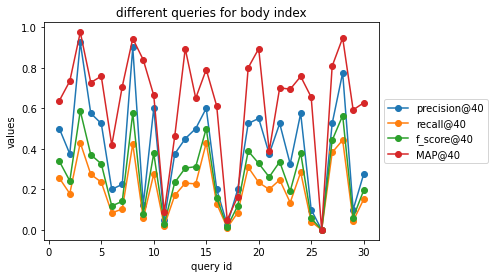

In [21]:


#true_relevancy = [(1,{'question': 'python','relevance_assessments' : query_python_true_list}),(2,{'question': 'why do men have nipples','relevance_assessments' : query_nipples_true_list})]
#predicted_relevancy_for_body = {1:body_search_result,2:few_body_search_result}
#print(predicted_relevancy_for_body)
#predicted_relevancy_for_title = {1:title_search_result,2:few_title_search_result}
#predicted_relevancy_for_anchor = {1:anchor_search_result,2:few_anchor_search_result}
#metrices_names = ['precision@k','recall@k','f_score@k','MAP@k']
metrices_names = ['precision@k','recall@k','f_score@k','MAP@k']
k_values = [1,3,5,10,20,30,40]
#k_values = [1,3,5,10]
# plot_metric_with_differnt_k_values(queries,search_res,metrices_names,k_values)
plot_metric_different_quieries(queries,search_res,metrices_names,40)